# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [314]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline


import time
import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [104]:
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx',header=1)
del feat_info['Unnamed: 0']


In [105]:
feat_info.head(1)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown


In [8]:
pd.read_excel?

In [3]:
feat_info.shape

(2259, 4)

In [ ]:
'''
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
'''

In [390]:
azdias = pd.read_csv('azdias_30k.csv')

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
azdias = pd.read_csv('azdias_30k.csv')
customers = pd.read_csv('customers_30k.csv')
azdias = azdias.sample(5000)
customer = customers.sample(5000)

In [29]:
azdias.shape

(5000, 367)

In [5]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,361023,839636,-1,8.0,21.0,12.0,NaN,NaN,NaN,21.0,...,2.0,3.0,6.0,5.0,1.0,9.0,8.0,4,1,1
1,192753,655813,-1,9.0,19.0,NaN,NaN,NaN,NaN,19.0,...,4.0,7.0,10.0,11.0,6.0,9.0,3.0,1,1,1
2,774378,584318,-1,1.0,19.0,NaN,NaN,NaN,NaN,19.0,...,3.0,2.0,3.0,11.0,4.0,9.0,2.0,1,1,3
3,221721,788710,-1,3.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,7.0,4.0,6.0,4.0,7.0,1,1,1
4,77614,289393,-1,3.0,21.0,15.0,NaN,NaN,NaN,17.0,...,2.0,2.0,3.0,4.0,1.0,9.0,3.0,4,1,2


In [64]:
feat_info2 = pd.read_csv('feat_info_c.csv')
feat_info2.head()

,Unnamed: 0,attribute,information_level,type,missing_or_unknown
0,0,AGER_TYP,person,categorical,"[-1,0]"
1,1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,2,ANREDE_KZ,person,categorical,"[-1,0]"
3,3,CJT_GESAMTTYP,person,categorical,[0]
4,4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [69]:
feat_info2[feat_info2.type == 'categorical'].attribute.tolist()

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [4]:
aa = azdias.isna().sum()[azdias.isna().sum().values != 0]
aa / azdias.shape[0]

AKT_DAT_KL                    0.082470
ALTER_HH                      0.082470
ALTER_KIND1                   0.909048
ALTER_KIND2                   0.966900
ALTER_KIND3                   0.993077
ALTER_KIND4                   0.998648
ALTERSKATEGORIE_FEIN          0.295041
ANZ_HAUSHALTE_AKTIV           0.104517
ANZ_HH_TITEL                  0.108848
ANZ_KINDER                    0.082470
ANZ_PERSONEN                  0.082470
ANZ_STATISTISCHE_HAUSHALTE    0.104517
ANZ_TITEL                     0.082470
ARBEIT                        0.109082
BALLRAUM                      0.105182
CAMEO_DEU_2015                0.111060
CAMEO_DEUG_2015               0.111060
CAMEO_INTL_2015               0.111060
CJT_GESAMTTYP                 0.005446
CJT_KATALOGNUTZER             0.005446
CJT_TYP_1                     0.005446
CJT_TYP_2                     0.005446
CJT_TYP_3                     0.005446
CJT_TYP_4                     0.005446
CJT_TYP_5                     0.005446
CJT_TYP_6                

In [8]:
customers.shape

(191652, 369)

In [12]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [ ]:
customers.isna().sum()[customers.isna().sum().values != 0] / customers.shape[0]

In [34]:
azdias.isna().sum(axis=1)[azdias.isna().sum(axis=1) !=0] / azdias.shape[1]

0         0.688525
1         0.040984
2         0.013661
3         0.019126
4         0.013661
5         0.010929
6         0.019126
7         0.016393
8         0.040984
9         0.010929
10        0.016393
11        0.691257
12        0.185792
13        0.196721
14        0.691257
15        0.352459
16        0.021858
17        0.691257
18        0.043716
19        0.043716
20        0.363388
21        0.043716
22        0.043716
23        0.352459
24        0.691257
25        0.021858
26        0.543716
27        0.013661
28        0.040984
29        0.016393
            ...   
891191    0.010929
891192    0.043716
891193    0.013661
891194    0.010929
891195    0.010929
891196    0.008197
891197    0.013661
891198    0.040984
891199    0.043716
891200    0.019126
891201    0.013661
891202    0.016393
891203    0.207650
891204    0.013661
891205    0.016393
891206    0.016393
891207    0.013661
891208    0.013661
891209    0.016393
891210    0.016393
891211    0.016393
891212    0.

## To fix list

- feat_info df is a mess
- Reflecting 'real' NAs in both azdias and customers csv based on the feature information df
- Remove columns with >30% missing values
- Removing rows with >40% missing values


#### Fixign the Feat Info DF

Cleaning list: 

-> names of columns to underscore

-> Add additional column with "Missing or Unkwnown"

In [106]:
feat_info.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [107]:
feat_info_ffill = feat_info['Attribute'].fillna(method='ffill')
feat_info_ffill_description = feat_info['Description'].fillna(method='ffill')

feat_info['Attribute'] = feat_info_ffill
feat_info['Description'] = feat_info_ffill_description
feat_info.head(3)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly


In [108]:
# Changing column names to lowercase
feat_info.rename(columns={"Attribute":'attribute','Description':'description','Value':'value','Meaning':'meaning'},inplace=True)

In [13]:
feat_info.head()

,attribute,description,value,meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [109]:
#Identifying the values that correspond to no date (either unknown or no transaction known)
feat_info.meaning.value_counts()[feat_info.meaning.value_counts()>3]

unknown                                                  232
average                                                  162
high                                                     154
low                                                      154
very high                                                142
very low                                                 139
none                                                     138
Multibuyer 0-12 months                                    34
no transaction known                                      34
Buyer > 24 months                                         34
Multi-/Doublebuyer 13-24 months                           34
Doublebuyer 0-12 months                                   34
Prospects > 24 months                                     34
Singlebuyer 0-12 months                                   34
Singlebuyer 13-24 months                                  34
no transactions known                                     22
very high affinity      

In [110]:
feat_missing = feat_info[((feat_info.meaning.str.contains('unknown') == True) | (feat_info.meaning.str.contains('no transaction') == True))]
feat_missing.reset_index(inplace=True)
feat_missing.rename(columns={'index':'old_index'},inplace=True)
print(feat_missing.shape)
feat_missing.head()

(289, 5)


,old_index,attribute,description,value,meaning
0,0,AGER_TYP,best-ager typology,-1,unknown
1,5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
2,11,ALTER_HH,main age within the household,0,unknown / no main age detectable
3,33,ANREDE_KZ,gender,"-1, 0",unknown
4,40,BALLRAUM,distance to next urban centre,-1,unknown


In [111]:
feat_missing.value.value_counts()

-1       138
-1, 9     75
0         47
-1, 0     16
10        12
-1         1
Name: value, dtype: int64

In [13]:
def convert_to_list(x):
    x_str = str(x)
    try: 
        x_str = x_str.split(sep=',')
    except: 
        pass
    
    x_str = [int(s) for s in x_str]
    return x_str

In [113]:
convert_to_list(feat_missing.value[1])

[-1, 0]

In [114]:
feat_missing['missing_or_unknown'] = feat_missing.value.apply(lambda x: convert_to_list(x))

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [115]:
feat_missing = feat_missing[['attribute','description','missing_or_unknown']]
print(feat_missing.shape)
feat_missing.head()

(289, 3)


,attribute,description,missing_or_unknown
0,AGER_TYP,best-ager typology,[-1]
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]"
2,ALTER_HH,main age within the household,[0]
3,ANREDE_KZ,gender,"[-1, 0]"
4,BALLRAUM,distance to next urban centre,[-1]


In [89]:
type(feat_missing.missing_or_unknown[0][0])

int

#### Reflecting real NAs based on the missing_or_unknown values from feat_missing df

In [31]:
azdias.head(3)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
22510,849326,324968,2,9.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,9.0,6.0,3.0,6.0,9.0,4.0,6,1,4
23832,122488,695745,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,...,2.0,9.0,12.0,10.0,3.0,8.0,8.0,3,2,3
15402,212352,1040619,1,1.0,12.0,NaN,NaN,NaN,NaN,12.0,...,1.0,1.0,2.0,1.0,6.0,9.0,2.0,3,2,4


In [32]:
azdias.isna().sum().sum()

193057

In [36]:
feat_missing[feat_missing.attribute == 'BIP_FLAG']

,attribute,description,missing_or_unknown
5,BIP_FLAG,business-flag indicating companies in the buil...,[-1]


In [151]:
feat_missing_idx = feat_missing.set_index('attribute')

In [39]:
azdias.isna().sum().sum()

194415

In [40]:
azdias.to_csv('azdias_30k_2.csv')
customers.to_csv('customers_30k_2.csv')

In [47]:
azdias = pd.read_csv('azdias_30k_2.csv')
azdias.shape

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5000, 368)

In [49]:
customers = pd.read_csv('customers_30k_2.csv')
customers = customers.sample(5000)
customers.shape

(5000, 371)

In [131]:
pd.DataFrame?

#### Removing cols with >30% missing values

In [6]:
aa = azdias.isna().sum()[azdias.isna().sum().values != 0] / azdias.shape[0]
aa[aa>0.3]

ALTER_KIND1     0.909048
ALTER_KIND2     0.966900
ALTER_KIND3     0.993077
ALTER_KIND4     0.998648
EXTSEL992       0.733996
KK_KUNDENTYP    0.655967
dtype: float64

In [42]:
cols_delete = aa[aa>0.3].index.tolist()

In [43]:
azdias.shape

(5000, 367)

In [44]:
azdias = azdias.loc[:, ~azdias.columns.isin(cols_delete)]
azdias.shape

(5000, 360)

In [17]:
aa = customers.isna().sum()[customers.isna().sum().values != 0] / customers.shape[0]

In [18]:
cols_delete_c = aa[aa>0.3].index.tolist()
cols_delete_c

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP']

In [46]:
customers.shape

(30000, 363)

In [45]:
customers = customers.loc[:, ~customers.columns.isin(cols_delete)]
customers.shape

(30000, 363)

### Removing rows with too many NA

In [52]:
aa = azdias.isna().sum(axis=1)[azdias.isna().sum(axis=1).values != 0] / azdias.shape[1]

In [43]:
aa[aa>0.5].shape[0] / isna.shape[0]

0.11130123729131158

In [47]:
rows_delete = aa[aa>0.5].index.tolist()

In [48]:
len(rows_delete)

99194

In [49]:
isna.shape

(891221, 360)

In [52]:
isna = isna.loc[~isna.index.isin(rows_delete), :]
isna.shape

(792027, 360)

In [55]:
aa = isna.isna().sum(axis=1)[customers.isna().sum(axis=1).values != 0] / customers.shape[1]

In [56]:
aa[aa>0.5].shape[0] / azdias.shape[0]

0.06407231066617679

In [57]:
rows_delete_c = aa[aa>0.5].index.tolist()

In [58]:
customers.shape

(191652, 363)

In [59]:
customers = customers.loc[~customers.index.isin(rows_delete_c), :]
customers.shape

(140905, 363)

In [37]:
np.setdiff1d(customers.columns, azdias.columns)

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

In [ ]:
customers_c

### Cleaning function

In [54]:
azdias.sample()

,Unnamed: 0,Unnamed: 0.1,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
220,2651,693457,471341,2.0,1.0,15.0,15.0,17.0,NaN,NaN,...,3.0,7.0,8.0,5.0,1.0,9.0,3.0,3,2,4.0


#### Saving the new csvs which can run faster

In [54]:
azdias_c.to_csv('azdias_c.csv')

In [60]:
customers_c.to_csv('customers_c.csv')

In [2]:
azdias_c = pd.read_csv('azdias_c.csv')
azdias_c.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(792027, 361)

In [3]:
customers_c = pd.read_csv('customers_c.csv')
customers_c.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(140905, 364)

In [4]:
feat_info_c = pd.read_csv('feat_info_c.csv')
feat_info_c.shape

(85, 5)

In [5]:
feat_info_c.head()

,Unnamed: 0,attribute,information_level,type,missing_or_unknown
0,0,AGER_TYP,person,categorical,"[-1,0]"
1,1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,2,ANREDE_KZ,person,categorical,"[-1,0]"
3,3,CJT_GESAMTTYP,person,categorical,[0]
4,4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
azdias_c.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
1,2,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
2,3,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
3,4,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
4,5,910244,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [96]:
azdias.sample()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
9940,315679,-1.0,1.0,18.0,NaN,NaN,NaN,NaN,18.0,7.0,...,1.0,6.0,7.0,4.0,4.0,4.0,5.0,5,1,2.0


In [137]:
feat_missing.head()

,attribute,description,missing_or_unknown
0,AGER_TYP,best-ager typology,[-1]
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]"
2,ALTER_HH,main age within the household,[0]
3,ANREDE_KZ,gender,"[-1, 0]"
4,BALLRAUM,distance to next urban centre,[-1]


In [15]:
def clean_df(df,na_percentage = 0.3):
    '''
    Input: DataFrame
    
    Output: clean DataFrame
    '''
    
    df = df.copy()

    
    print(f'original shape of df : {df.shape}')
    
    
    # Converting values into NAs
    for col in df.columns:
        try:
            df[col] = df[col].replace(feat_missing_idx.loc[col,'missing_or_unknown'],np.NaN)
        except:  pass
    
    
    
    #Remove columns -- These come from the first project, also on Github
    print('Delete columns with too many NAs or not relevant for analysis')
    col_delete = ['TITEL_KZ', 
    'AGER_TYP', 
    'KK_KUNDENTYP',
    'KBA05_BAUMAX',
    'GEBURTSJAHR',
    'ALTER_HH',
    'CJT_GESAMTTYP',
    'FINANZTYP',
    'GFK_URLAUBERTYP',
    'LP_FAMILIE_FEIN',
    'LP_FAMILIE_GROB',
    'LP_STATUS_FEIN',
    'LP_STATUS_GROB',
    'NATIONALITAET_KZ',
    'SHOPPER_TYP',
    'ZABEOTYP',
    'GEBAEUDETYP',
    'CAMEO_DEUG_2015',
    'CAMEO_DEU_2015',
    'CAMEO_INTL_2015',
    'PRAEGENDE_JUGENDJAHRE', 
    'ALTER_KIND1',
    'ALTER_KIND2',
    'ALTER_KIND3',
    'ALTER_KIND4',
    'EXTSEL992',
    'D19_TELKO_ONLINE_DATUM',
    'D19_BANKEN_OFFLINE_DATUM',
    'D19_TELKO_ANZ_12',
    'D19_BANKEN_ANZ_12',
    'D19_TELKO_ANZ_24',
    'D19_VERSI_ANZ_12',
    'D19_TELKO_OFFLINE_DATUM',
    'D19_BANKEN_ANZ_24',
    'D19_VERSI_ANZ_24',
    'D19_BANKEN_ONLINE_DATUM',
    'D19_BANKEN_DATUM',
    'D19_TELKO_DATUM',
    'D19_VERSAND_ANZ_12',
    'D19_VERSAND_OFFLINE_DATUM',
    'D19_GESAMT_ANZ_12',
    'D19_VERSAND_ANZ_24',
    'D19_GESAMT_OFFLINE_DATUM',
    'D19_GESAMT_ANZ_24',
    'D19_VERSAND_ONLINE_DATUM',
    'D19_GESAMT_ONLINE_DATUM',
    'D19_VERSAND_DATUM',
    'D19_GESAMT_DATUM',
    'D19_LETZTER_KAUF_BRANCHE',
    'EINGEFUEGT_AM']
    
    df = df.loc[:, ~df.columns.isin(col_delete)]
    
    # Change these three columns to binary encoding (1,0)
    
    df['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    df['OST_WEST_KZ'].replace(['O','W'],[1,0],inplace=True)
    
     # Categorical features
    cat_feature = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ',
       'VERS_TYP']
    
    
        
    #Removing rows with too many Nans
    print(f'removing rows with {na_percentage} NaNs')
    nan_rows = df.isna().sum(axis=1)[df.isna().sum(axis=1).values != 0] / df.shape[1]
    print(f'Rows with more than {na_percentage} of missing values {nan_rows[nan_rows>na_percentage].shape[0]/df.shape[0]} of total')
    
    rows_delete = nan_rows[nan_rows > na_percentage].index.tolist()
    df = df.loc[~df.index.isin(rows_delete), :]
    
    print(f'new shape : {df.shape}')
    
    return df

In [179]:
missing_va = azdias_c.isna().sum()[azdias_c.isna().sum().values != 0].sort_values(ascending=False).to_frame()
missing_va.rename(columns={0:'na_n'},inplace=True)
missing_va['na_percentage'] = missing_va/azdias_c.shape[0]
missing_va[missing_va.na_percentage > 0.25].index.to_list()

[]

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [199]:
azdias = pd.read_csv('azdias_30k.csv')
azdias.drop('Unnamed: 0',axis=1,inplace=True)
azdias = azdias.sample(1000)
print(azdias.shape)
azdias.sample()

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1000, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
13441,719544,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,1.0,...,4.0,7.0,9.0,6.0,5.0,9.0,5.0,6,1,4


In [265]:
azdias.isna().sum().sum()

38623

In [200]:
azdias_c = clean_df(azdias)
print(azdias_c.shape)
azdias_c.sample()

original shape of df : (1000, 366)
Delete columns with too many NAs or not relevant for analysis
removing rows with 0.3 NaNs
Rows with more than 0.3 of missing values 0.119 of total
new shape : (881, 316)
(881, 316)


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
20530,692031,1.0,14.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,1.0,3.0,1.0,1.0,1.0,4.0,9.0,1.0,1,3


In [267]:
azdias_c.isna().sum().sum()

6068

In [268]:
azdias_c.sample()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
4258,747445,9.0,NaN,11.0,0.0,0.0,3.0,6.0,0.0,3.0,...,0.0,1.0,7.0,10.0,7.0,2.0,8.0,5.0,0,2


In [270]:
imputer = Imputer()
col_names = azdias_c.columns
azdias_array = imputer.fit_transform(azdias_c)
azdias_c = pd.DataFrame(azdias_array,columns=col_names)

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [271]:
azdias_c.sample()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
236,971102.0,3.0,16.0,6.0,0.0,0.0,1.0,5.0,0.0,5.0,...,0.0,4.0,5.0,8.0,8.0,6.0,6.0,4.0,0.0,2.0


## PCA: Principal Component Analysis

In this part I will proceed to reduce significantly the number of features that we have by Using PCA to reduce dimensionality

In [201]:
# Categorical features
cat_feature = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ',
   'VERS_TYP']
azdias_c = pd.get_dummies(azdias_c,columns=cat_feature)

In [284]:
# Standard Scaler
scaler = StandardScaler()
df_cols = azdias_c.columns
df_ss = scaler.fit_transform(azdias_c)
df_ss = pd.DataFrame(df_ss)
df_ss.columns = df_cols
df_ss.head()

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,ANREDE_KZ_1.0,GREEN_AVANTGARDE_0.0,GREEN_AVANTGARDE_1.0,OST_WEST_KZ_0.0,OST_WEST_KZ_1.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_0.0,VERS_TYP_0.498220640569395,VERS_TYP_1.0
0,-1.322130,1.215287,-6.303614e-01,-0.368967,-0.138021,-0.321954,0.293751,-0.451925,-0.058587,0.850628,...,0.870353,0.497504,-0.497504,-1.927447,1.927447,0.095948,-0.095948,-0.965255,-0.200829,1.043118
1,-1.196058,1.215287,1.387522e+00,3.674150,-0.138021,-0.321954,-0.653380,2.870674,-0.058587,0.850628,...,0.870353,0.497504,-0.497504,-1.927447,1.927447,0.095948,-0.095948,-0.965255,4.979369,-0.958664
2,1.249873,0.391846,-1.819430e-01,0.709198,-0.138021,-0.321954,-0.653380,0.813827,-0.058587,0.850628,...,0.870353,0.497504,-0.497504,0.518821,-0.518821,0.095948,-0.095948,-0.965255,4.979369,-0.958664
3,1.358462,-0.980555,-3.096663e+00,-0.503738,-0.138021,-0.321954,-0.653380,-0.531035,-0.058587,-0.122473,...,-1.148959,0.497504,-0.497504,0.518821,-0.518821,0.095948,-0.095948,1.035995,-0.200829,-0.958664
4,-0.066156,1.215287,3.982756e-16,-0.368967,-0.138021,-0.321954,-0.653380,-0.293706,-0.058587,-0.122473,...,-1.148959,0.497504,-0.497504,0.518821,-0.518821,0.095948,-0.095948,1.035995,-0.200829,-0.958664


In [16]:
def impute_and_ss(df):
    '''
    input: DataFrame
    Output : DataFrame after imputing and standardscaling
    '''
    imputer = Imputer()
    col_names = df.columns
    df_array = imputer.fit_transform(df)
    df = pd.DataFrame(df_array,columns=col_names)
    
    scaler = StandardScaler()
    df_cols = df.columns
    df_ss = scaler.fit_transform(df)
    df_ss = pd.DataFrame(df_ss)
    df_ss.columns = df_cols
    
    cat_feature = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ',
   'VERS_TYP']
    df_ss = pd.get_dummies(df_ss,columns=cat_feature)
    
    return df_ss

In [287]:
n_components = int(round(df_ss.shape[1] / 2,0))
pca = PCA(n_components)
df_pca = pca.fit_transform(df_ss)

In [288]:
components = pca.explained_variance_ratio_
cum_com = np.cumsum(components)
num_com = np.arange(n_components)
components

array([0.08043661, 0.05736223, 0.04686952, 0.03549414, 0.02783107,
       0.02531199, 0.02126524, 0.01929598, 0.01715571, 0.01563517,
       0.01549117, 0.0141359 , 0.01236327, 0.01148711, 0.01099412,
       0.010615  , 0.01022441, 0.00998316, 0.00961116, 0.00945504,
       0.00920787, 0.00872985, 0.00854558, 0.00830149, 0.00804691,
       0.00774624, 0.0073509 , 0.00730614, 0.00706238, 0.00700805,
       0.00683416, 0.00671698, 0.0066543 , 0.00628632, 0.00623588,
       0.00613011, 0.00596256, 0.00574913, 0.00568045, 0.00560291,
       0.00554078, 0.00544189, 0.00530215, 0.00527035, 0.00517473,
       0.00502977, 0.00494613, 0.00479415, 0.00460269, 0.00459096,
       0.00450233, 0.00441779, 0.00438229, 0.00436494, 0.00427678,
       0.00421904, 0.00413669, 0.00409555, 0.00400469, 0.0039348 ,
       0.00392482, 0.00384091, 0.00377444, 0.00374195, 0.00370984,
       0.00365406, 0.00360588, 0.00355395, 0.00352906, 0.00349705,
       0.00348676, 0.00341062, 0.00336265, 0.00331145, 0.00329

''

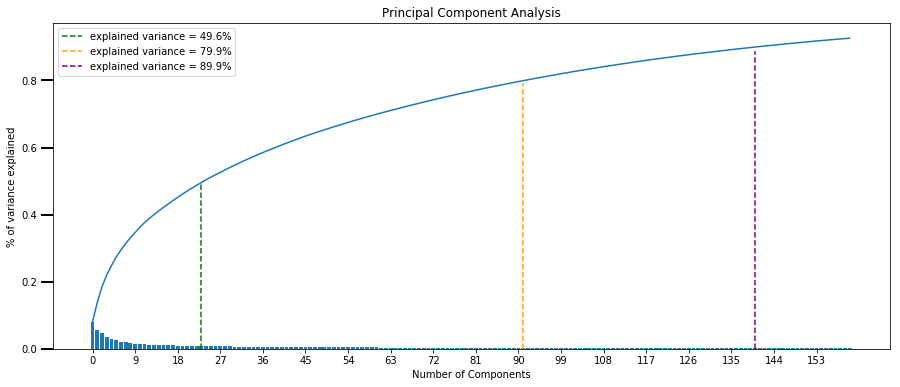

In [292]:
plt.figure(figsize=(15,6))
ax = plt.subplot(111)
ax.plot(num_com,cum_com)
ax.bar(num_com,components)

ax.yaxis.set_tick_params(width=2, length=12)
plt.xticks(num_com)
plt.locator_params(axis='x',nbins=20)
plt.title('Principal Component Analysis')
plt.xlabel('Number of Components')
plt.ylabel('% of variance explained')
#ax.set_xlim(-0.5, n_components)

# Drawing vertical lines to give when 50%, 80%, 90% and 95% of the variance is explained
thres = [0.5,0.8,0.9]
colors = ['green','orange','purple']
count = 0
for p in thres:
    n_c = len(cum_com[cum_com<=p]) -1
    y_max = cum_com[n_c]
    plt.axvline(x=n_c,ymax=y_max +0.015,linestyle='dashed',color=colors[count],label='explained variance = {0:.01f}%'.format(y_max*100))
    plt.legend()
    count +=1
    #plt.axhline(y=y_max,xmax=(n_c-0.5)/(len(num_com)-0.5))
;

Based on this graph I choose to keep around 90 of the components that explain 80% of the variance

In [293]:
n_components = 90
pca_fin = PCA(n_components)
df_pca_fin = pca_fin.fit_transform(df_ss)

In [294]:
components = pd.DataFrame(np.round(pca_fin.components_,4), columns = df_ss.keys())
components[:2]

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,ANREDE_KZ_1.0,GREEN_AVANTGARDE_0.0,GREEN_AVANTGARDE_1.0,OST_WEST_KZ_0.0,OST_WEST_KZ_1.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_0.0,VERS_TYP_0.498220640569395,VERS_TYP_1.0
0,-0.0351,0.0595,0.0318,0.0868,0.0154,-0.0199,-0.0561,0.0894,-0.0001,0.1061,...,-0.0064,0.0637,-0.0637,-0.0573,0.0573,0.0095,-0.0095,-0.0238,0.0171,0.0172
1,-0.0731,-0.0409,-0.0107,-0.0223,-0.0253,0.0219,0.0369,-0.0252,-0.0029,0.0273,...,-0.0179,0.0387,-0.0387,-0.0961,0.0961,0.0168,-0.0168,0.0280,-0.0215,-0.0197


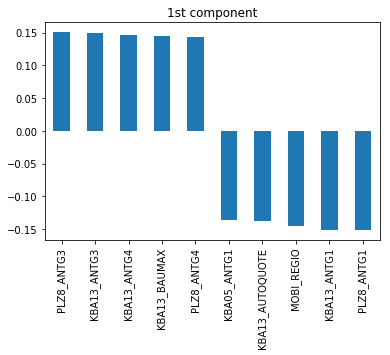

In [295]:
ratios = pca_fin.explained_variance_ratio_.reshape(len(pca_fin.components_),1)
variance_ratios = pd.DataFrame(np.round(ratios,4), columns = ['explained variance'])
compn = components.iloc[0]
compn.sort_values(ascending=False, inplace = True)
compn = pd.concat([compn.head(5),compn.tail(5)])
compn.plot(kind='bar', title = '1st component')

''

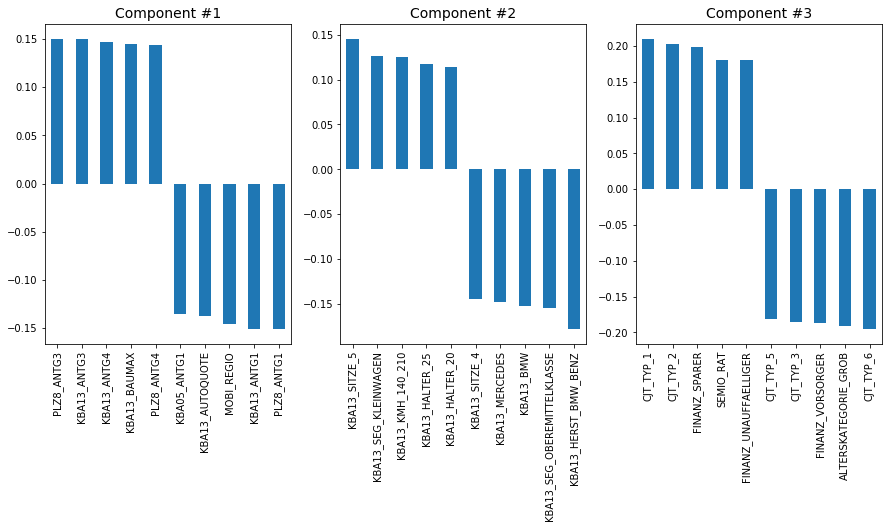

In [297]:
n_comp = 3
base_color = sns.color_palette()[0]


plt.figure(figsize=[15,20])
for comp in range(0,n_comp):
    compn = components.iloc[comp]
    compn.sort_values(ascending=False, inplace=True)
    compn = pd.concat([compn.head(5),compn.tail(5)])
    
    plt.subplot(n_comp,3,comp+1)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Component #' + str(comp+1),fontsize=14)
    compn.plot(kind='bar',color=base_color)
;

### Clustering using KMeans

In [300]:
k_n = 3
k_means = KMeans(3)
k_model = k_means.fit(df_ss)
k_labels = k_model.predict(df_ss)

In [312]:
dimen = []
for comp in range(0,n_comp):
    compn = components.iloc[comp]
    compn.sort_values(ascending=False, inplace=True)
    dimen.append(compn.head().index[0])
    print(compn.head(1))

PLZ8_ANTG3    0.1506
Name: 0, dtype: float64
KBA13_SITZE_5    0.1456
Name: 1, dtype: float64
CJT_TYP_1    0.2104
Name: 2, dtype: float64


In [313]:
dimen

['PLZ8_ANTG3', 'KBA13_SITZE_5', 'CJT_TYP_1']

In [308]:
compn.head(1)

CJT_TYP_1    0.2104
Name: 2, dtype: float64

In [323]:
def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure()
    dimen_1, dimen_2, dimen_3 = dimen[0], dimen[1], dimen[2]
    ax = Axes3D(fig)
    ax.set_xlabel(dimen_1)
    ax.set_ylabel(dimen_2)
    ax.set_zlabel(dimen_3)
    ax.scatter(data[[dimen_1]], data[[dimen_2]], data[[dimen_3]], c=labels, cmap='tab10')
    plt.legend();

No handles with labels found to put in legend.


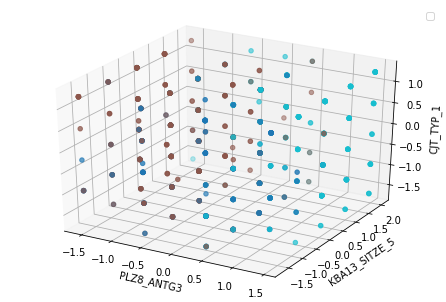

In [324]:
plot_data(df_ss,k_labels)

In [327]:
k_n = []
k_n_score = []

start_time = time.time()

for i in range(0,25):
    
    kmeans = KMeans(i+1)
    model = kmeans.fit(df_ss)
    score = np.abs(model.score(df_ss))
    k_n.append(i+1)
    k_n_score.append(score)
    print('--- run time for round with K = {} : {} mins ---'.format(i+1,np.round(((time.time() - start_time)/60),2)))
k_score_table = pd.DataFrame()
k_score_table['k_n'] = k_n
k_score_table['k_n_score'] = k_n_score
print('--total run time : %s mins -- ' % np.round(((time.time() - start_time)/60),2))

k_score_table

--- run time for round with K = 1 : 0.0 mins ---
--- run time for round with K = 2 : 0.01 mins ---
--- run time for round with K = 3 : 0.01 mins ---
--- run time for round with K = 4 : 0.02 mins ---
--- run time for round with K = 5 : 0.03 mins ---
--- run time for round with K = 6 : 0.04 mins ---
--- run time for round with K = 7 : 0.05 mins ---
--- run time for round with K = 8 : 0.06 mins ---
--- run time for round with K = 9 : 0.07 mins ---
--- run time for round with K = 10 : 0.08 mins ---
--- run time for round with K = 11 : 0.09 mins ---
--- run time for round with K = 12 : 0.1 mins ---
--- run time for round with K = 13 : 0.12 mins ---
--- run time for round with K = 14 : 0.13 mins ---
--- run time for round with K = 15 : 0.14 mins ---
--- run time for round with K = 16 : 0.15 mins ---
--- run time for round with K = 17 : 0.17 mins ---
--- run time for round with K = 18 : 0.18 mins ---
--- run time for round with K = 19 : 0.2 mins ---
--- run time for round with K = 20 : 0.21 m

,k_n,k_n_score
0,1,282394.000000
1,2,265860.669262
2,3,258312.835695
3,4,252747.720416
4,5,248234.940136
5,6,244535.349069
6,7,241699.237960
7,8,239071.634393
8,9,237251.881690
9,10,235615.455819


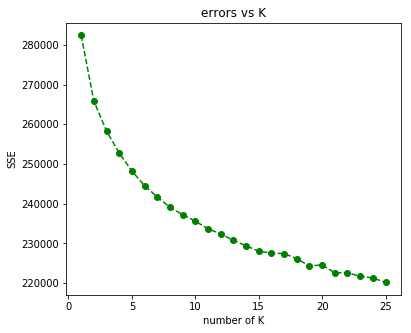

In [328]:
plt.figure(figsize=(6,5))
plt.plot(k_score_table.k_n,k_score_table.k_n_score,linestyle='--',marker= 'o', color='g')
plt.xlabel('number of K')
plt.ylabel('SSE')
plt.title('errors vs K');

I choose to have 15 clusters, as the SSE continued to fall. We could reduce it even more but having too many clusters is also inconvenient

In [363]:
k_n = 15
k_means = KMeans(k_n)
k_model = k_means.fit(df_ss)
k_labels = k_model.predict(df_ss)

#After PCA
k_n = 15
k_means_pca = KMeans(k_n)
k_model_pca = k_means_pca.fit(df_pca_fin)
k_labels_pca = k_model_pca.predict(df_pca_fin)


### Clustering Customers

In [391]:
azdias_c = azdias.sample(1000)
azdias_c = clean_df(azdias_c)
azdias_c = impute_and_ss(azdias_c)
azdias_c.dropna(inplace=True)

original shape of df : (1000, 367)
Delete columns with too many NAs or not relevant for analysis
removing rows with 0.3 NaNs
Rows with more than 0.3 of missing values 0.133 of total
new shape : (867, 317)


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [359]:
customers = pd.read_csv('customers_30k.csv')
customers = customers[azdias.columns]
customers = customers.sample(1000)
print(f'original shape of customers df {customers.shape}')
customers = clean_df(customers)

print(f'shape of customers df after cleaning {customers.shape}')
customers = impute_and_ss(customers)
customers.dropna(inplace=True)
customers.shape


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


original shape of customers df (1000, 366)
original shape of df : (1000, 366)
Delete columns with too many NAs or not relevant for analysis
removing rows with 0.3 NaNs
Rows with more than 0.3 of missing values 0.252 of total
new shape : (748, 316)
shape of customers df after cleaning (748, 316)


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(748, 322)

In [360]:
customers.sample()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,ANREDE_KZ_1.3267055443752447,GREEN_AVANTGARDE_-0.9428090415820632,GREEN_AVANTGARDE_1.0606601717798212,OST_WEST_KZ_-0.29797961107628845,OST_WEST_KZ_3.3559343083509865,SOHO_KZ_-0.08203337796861788,SOHO_KZ_12.19015996613662,VERS_TYP_-1.0472296798966307,VERS_TYP_0.0,VERS_TYP_0.9704693892235792
64,-0.510622,-0.36807,-0.534002,-0.302065,-0.140837,-0.276881,-1.548251,-0.282341,-0.148786,-0.804323,...,0,1,0,1,0,1,0,1,0,0


In [364]:
customers_pca = pca_fin.transform(customers)
customers_cluster = k_model_pca.predict(customers_pca)


In [365]:
pop_gen, pop_cus = [], []

for i in np.unique(customers_cluster):
    gen = (k_labels_pca == i).sum() / len(k_labels_pca)
    pop_gen.append(gen)
    
    cus = (customers_cluster == i).sum() / len(customers_cluster)
    pop_cus.append(cus)

df_comp = pd.DataFrame()
df_comp['cluster'] = [i for i in range(len(pop_gen))]
df_comp['general_pop'] = pop_gen
df_comp['customer_pop'] = pop_cus
df_comp

,cluster,general_pop,customer_pop
0,0,0.050171,0.045455
1,1,0.049031,0.020053
2,2,0.077537,0.033422
3,3,0.082098,0.060160
4,4,0.070696,0.098930
5,5,0.076397,0.109626
6,6,0.034208,0.057487
7,7,0.047891,0.066845
8,8,0.076397,0.061497
9,9,0.041049,0.033422


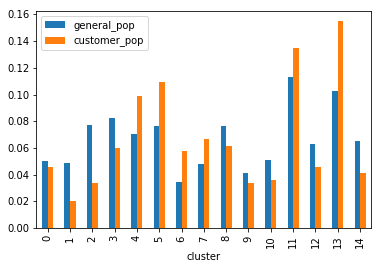

In [366]:
df_comp.plot(x='cluster', y = ['general_pop','customer_pop'], kind='bar')

In [369]:
len(customers_cluster)

748

In [380]:
azdias.mean().tolist()

[646276.919,
 -0.427,
 4.588876772082879,
 10.944383860414394,
 11.968421052631578,
 13.774193548387096,
 15.666666666666666,
 13.0,
 13.85531914893617,
 8.393296089385474,
 0.04591265397536394,
 0.14830970556161396,
 1.6946564885496183,
 7.637988826815643,
 0.003271537622682661,
 3.1221973094170403,
 4.249162011173184,
 3.717741935483871,
 3.2631048387096775,
 3.4163306451612905,
 3.215725806451613,
 3.34375,
 3.345766129032258,
 3.3669354838709675,
 3.4506048387096775,
 0.112,
 0.233,
 9.262,
 0.908,
 0.565,
 0.185,
 9.934,
 9.438,
 0.6547277936962751,
 0.435,
 0.415,
 1.162,
 0.528,
 0.284,
 1.636,
 0.183,
 0.588,
 0.318,
 0.652,
 0.315,
 0.828,
 1.28,
 6.978,
 9.021,
 7.563,
 3.9398280802292263,
 0.818,
 1.05,
 0.771,
 5.330945558739255,
 5.937,
 0.955,
 0.326,
 1.191977077363897,
 0.229,
 0.535,
 0.972,
 0.635,
 0.521,
 2.191,
 0.6303724928366762,
 1.697,
 0.043,
 0.088,
 9.452,
 1.009,
 9.825,
 9.986,
 0.014326647564469915,
 0.761,
 0.27,
 0.658,
 1.003,
 7.569,
 9.338,
 7.802,
 

In [381]:
customers_by_cluster = pd.DataFrame({'idx':np.arange(0,len(customers_cluster)),'cluster':customers_cluster})

In [397]:
customers.shape, azdias_c.shape

((748, 322), (867, 322))

In [413]:
cluster_13_mean = customers.loc[customers_by_cluster[customers_by_cluster.cluster == 13].idx,:].median()
avg_person_mean = azdias_c.median()
comp_13_avg = pd.DataFrame({'azdias':avg_person_mean,'cluster_13':cluster_13_mean,'diff':cluster_13_mean-avg_person_mean})

In [414]:
print(comp_13_avg.nsmallest(3,'diff').index)
comp_13_avg.nsmallest(3,'diff')

Index(['STRUKTURTYP', 'RELAT_AB', 'HH_EINKOMMEN_SCORE'], dtype='object')


,azdias,cluster_13,diff
STRUKTURTYP,0.575943,-0.831336,-1.407278
RELAT_AB,-0.039227,-1.367007,-1.327780
HH_EINKOMMEN_SCORE,0.415467,-0.827863,-1.243330


In [415]:
print(comp_13_avg.nlargest(3,'diff').index)
comp_13_avg.nlargest(3,'diff')

Index(['WOHNLAGE', 'D19_TECHNIK', 'D19_VOLLSORTIMENT'], dtype='object')


,azdias,cluster_13,diff
WOHNLAGE,-0.514428,1.608484,2.122912
D19_TECHNIK,-0.679838,0.981621,1.661459
D19_VOLLSORTIMENT,-0.698852,0.954549,1.653400


The customer population seems over=represented in clusters 13, 11, 5, and 4

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [149]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('mailout_train.csv',index_col = 'Unnamed: 0')

In [3]:
print(mailout_train.shape)
mailout_train.sample()

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
32880,85194,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,1


In [4]:
mailout_train = mailout_train.sample(10000)

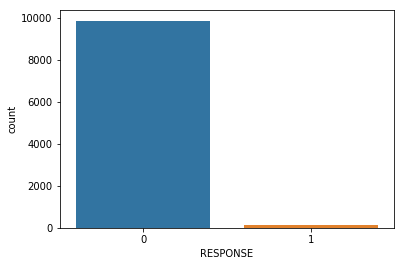

In [5]:
sns.countplot('RESPONSE',data=mailout_train)

In [6]:
corr_factors = pd.DataFrame(mailout_train.corr().loc[:,'RESPONSE'].sort_values(ascending=False)).reset_index()
corr_factors = corr_factors[1:5].append(corr_factors.tail(7)[:-3])


In [7]:
corr_factors

,index,RESPONSE
1,KBA13_CCM_3000,0.043737
2,KBA13_SITZE_6,0.041467
3,RT_SCHNAEPPCHEN,0.037592
4,KBA05_DIESEL,0.035807
354,CJT_TYP_2,-0.032287
355,D19_SOZIALES,-0.036180
356,KBA13_SITZE_5,-0.041282
357,D19_KONSUMTYP,-0.042056


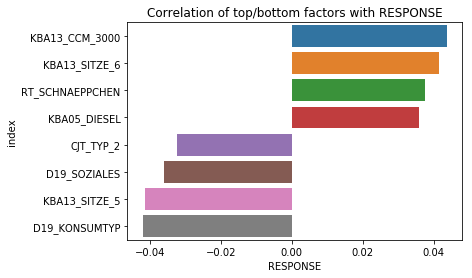

In [8]:
sns.barplot(y='index', x='RESPONSE',data=corr_factors)
plt.title('Correlation of top/bottom factors with RESPONSE');

### Separating Data Into Training and Testing

In [9]:
mailout_train.sample()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
29439,64866,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,3


In [291]:
X = mailout_train.loc[:,~mailout_train.columns.isin(['RESPONSE'])]

In [11]:
X.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
5801,22343,1,1.0,7.0,NaN,NaN,NaN,NaN,7.0,2.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,1,1,4
40,11299,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,1.0,...,2.0,4.0,6.0,3.0,6.0,9.0,7.0,1,2,4
29764,83454,3,1.0,8.0,NaN,NaN,NaN,NaN,8.0,1.0,...,3.0,6.0,4.0,2.0,6.0,9.0,7.0,3,2,1


Seems like there are a lot of NaNs! Perhaps we need to clean the df? 

In [292]:
X = clean_df(X)
print(X.shape)
X.head(3)

original shape of df : (42962, 366)
Delete columns with too many NAs or not relevant for analysis
removing rows with 0.3 NaNs
Rows with more than 0.3 of missing values 0.18532656766444766 of total
new shape : (35000, 316)
(35000, 316)


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,1,4
1,1771,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,3
2,1776,1.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,...,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,0,4


In [293]:
y = mailout_train.loc[X.index,'RESPONSE']

In [153]:
X.isna().sum().sum()

74742

In [294]:
X = impute_and_ss(X)

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [155]:
X.isna().sum().sum()

0

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

### Building ML algorithms

Trying out first with Random Forest. I choose to have [Precision](https://towardsdatascience.com/precision-vs-recall-386cf9f89488) as the main metric. This is the best description I've read to distinguish between Precision and Recall "What are the chances that Jack will be able to recall all such instances precisely? If you understood what I asked in the previous sentence with a cent per cent confidence, you have probably understood what recall and precision actually means. But, just to double check, here is my analysis. if Jack had let’s say ten such instances in reality, and he narrated twenty instances to finally spell out the ten correct instances, then his recall will be a 100%, but his precision will only be 50%."

I use Precision because it is more intuitive to understand. Later on I'll use ROC_AUC as this is the one used to measure in the Kaggle competition

In [23]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
f1_score(y_test,y_pred)


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

The model basically predicts that no one will respond :( . Need to optimize the parameters

In [288]:
def clf_output(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,clf=RandomForestClassifier()):
      
    print('Training Classifier')
    clf.fit(X_train,y_train)
    
    print('Predicting')
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    #f1_score = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test,y_pred)

    
    print(f'accuracy score : {accuracy}. Out of every 100, {accuracy*100} were accurately labeled)')
    print(f'precision score : {precision}. Out of every 100 predicted as response, {precision * 100} were correct')
    print(f'recall score : {recall}. Out of every 100 who responded, our model caught {recall * 100}')
    #print(f'f1_score {f1_score} mix between precision and recall ')
    print(f'auc_score : {auc_score}')
    

In [25]:
clf_output(clf=RandomForestClassifier())

Training Classifier
Predicting

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



accuracy score : 0.9833005893909627. Out of every 100, 98.33005893909626 were accurately labeled)
precision score : 0.0. Out of every 100 predicted as response, 0.0 were correct
recall score : 0.0. Out of every 100 who responded, our model caught 0.0


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
clf_output(clf=AdaBoostClassifier())

Training Classifier
Predicting
accuracy score : 0.9833005893909627. Out of every 100, 98.33005893909626 were accurately labeled)
precision score : 0.5. Out of every 100 predicted as response, 50.0 were correct
recall score : 0.029411764705882353. Out of every 100 who responded, our model caught 2.941176470588235


In [289]:
clf_output(clf=GaussianNB())

Training Classifier
Predicting
accuracy score : 0.8657142857142858. Out of every 100, 86.57142857142858 were accurately labeled)
precision score : 0.02559576345984113. Out of every 100 predicted as response, 2.559576345984113 were correct
recall score : 0.29. Out of every 100 who responded, our model caught 28.999999999999996
auc_score : 0.5811849710982661


Out of all these models, onnly the Naive Bayes classifier did remotely well if we consider precision and recall as important metrics. We'll need to do better by e.g. including Grid Search

### Using GridSearch 

In [285]:
ada_param_grid = {
              "n_estimators": [2,10,5,40],
              "learning_rate" : [0.01, 0.1, 0.5, 1.0]
             }

In [45]:
rf_param_grid = {
    'min_samples_split' : [2,5,10],
    'min_samples_leaf'  : [1,2,5,10],
    'max_depth':[2,6,10,20]}

In [318]:
gboost_params = {
    'learning_rate' : [0.01,0.1,0.2],
    'n_estimators' : [50,100,120],
    'criterion' : ['friedman_mse','mae'],
    'min_samples_split' : [2,5],
    'min_samples_leaf' : [1,2],
    'max_depth' : [3,5]
}

In [315]:
GradientBoostingRegressor?

Thanks [StackOverflow](https://stackoverflow.com/questions/32210569/using-gridsearchcv-with-adaboost-and-decisiontreeclassifier)

In [72]:
GridSearchCV?

In [286]:
def clf_GridSearch(clf=RandomForestClassifier(),params_clf=rf_param_grid,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    clf = clf
    scorer = make_scorer(roc_auc_score)
    cv = GridSearchCV(estimator=clf,param_grid=params_clf, scoring=scorer)
    print('Fitting  using GridSearch')
    cv_fit = cv.fit(X_train,y_train)
    best_clf = cv_fit.best_estimator_
    print(f'Best Params {best_clf}')
    pred_cv_clf = best_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, pred_cv_clf)
    precision = precision_score(y_test, pred_cv_clf)
    recall = recall_score(y_test, pred_cv_clf)
    #f1_score = f1_score(y_test, y_pred)
    
    print(f'accuracy score : {accuracy}. Out of every 100, {accuracy*100} were accurately labeled)')
    print(f'precision score : {precision}. Out of every 100 predicted as response, {precision * 100} were correct')
    print(f'recall score : {recall}. Out of every 100 who responded, our model caught {recall * 100}')
    
    return pred_cv_clf
    

In [87]:
clf_GridSearch(clf=RandomForestClassifier())

Fitting  using GridSearch


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted',

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted',

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted',

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted',

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted',

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted',

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted',

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted',

Best Params RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
accuracy score : 0.9833005893909627. Out of every 100, 98.33005893909626 were accurately labeled)
precision score : 0.0. Out of every 100 predicted as response, 0.0 were correct
recall score : 0.0. Out of every 100 who responded, our model caught 0.0


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted

In [ ]:
pred_cv_clf = clf_GridSearch(clf=GradientBoostingRegressor(),params_clf=gboost_params)

Fitting  using GridSearch


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [88]:
clf_GridSearch(clf=AdaBoostClassifier(),params_clf=ada_param_grid)

Fitting  using GridSearch


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no 

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Best Params AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=40, random_state=None)
accuracy score : 0.9833005893909627. Out of every 100, 98.33005893909626 were accurately labeled)
precision score : 0.5. Out of every 100 predicted as response, 50.0 were correct
recall score : 0.029411764705882353. Out of every 100 who responded, our model caught 2.941176470588235


## Results from the best Classifier - AdaBoost

In [107]:
best_params_ada = {'base_estimator':None, 
                  'learning_rate': 1.0, 
                  'n_estimators': 40}

In [272]:
clf_ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=40, random_state=None)
clf_ada.fit(X_train,y_train)
y_pred = clf_ada.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
#f1_score = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test,y_pred)

print(f'accuracy score : {accuracy}. Out of every 100, {accuracy*100} were accurately labeled)')
print(f'precision score : {precision}. Out of every 100 predicted as response, {precision * 100} were correct')
print(f'recall score : {recall}. Out of every 100 who responded, our model caught {recall * 100}')
#print(f'f1_score: {f1_score}')
print(f'auc_score : {auc_score}')

accuracy score : 0.9885714285714285. Out of every 100, 98.85714285714286 were accurately labeled)
precision score : 0.0. Out of every 100 predicted as response, 0.0 were correct
recall score : 0.0. Out of every 100 who responded, our model caught 0.0
auc_score : 0.5


C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
clf.

In [162]:
features_importance = pd.DataFrame(index=range(0,len(X_train.columns)))
features_importance['feature'] = X_train.columns
features_importance['weight'] = clf_ada.feature_importances_
features_importance = features_importance.sort_values(by='weight',ascending=False)
features_importance_top10 = features_importance[:10]

In [171]:
features_importance.shape

(322, 2)

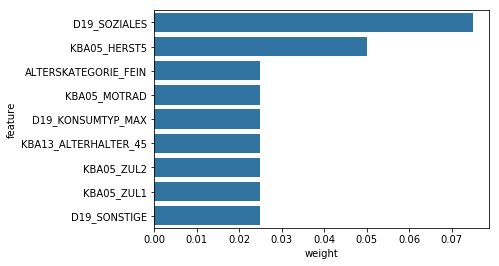

In [279]:
sns.barplot(data=features_importance_top10[1:],x='weight',y='feature',color=sns.color_palette()[0])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [210]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv('mailout_test.csv',index_col = 'Unnamed: 0')

In [166]:
print(mailout_test.shape)
mailout_test.head()

(42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [295]:
X_kaggle = clean_df(mailout_test,na_percentage=1)

original shape of df : (42833, 366)
Delete columns with too many NAs or not relevant for analysis
removing rows with 1 NaNs
Rows with more than 1 of missing values 0.0 of total
new shape : (42833, 316)


In [297]:
cat_feature = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ',
   'VERS_TYP']
X_kaggle = pd.get_dummies(X_kaggle,columns=cat_feature)

In [299]:
imputer = Imputer()
col_names = X_kaggle.columns
df_array = imputer.fit_transform(X_kaggle)
df = pd.DataFrame(df_array,columns=col_names)

scaler = StandardScaler()
df_cols = df.columns
df_ss = scaler.fit_transform(df)
df_ss = pd.DataFrame(df_ss)
df_ss.columns = df_cols

df_ss.shape

C:\users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(42833, 322)

In [306]:
clf_ada = GaussianNB()
clf_ada.fit(X,y)
y_pred = clf_ada.predict(df_ss)


In [307]:
len(y_pred)

42833

In [308]:
solution = pd.DataFrame(index=range(len(y_pred)))
solution["LNR"] = X_kaggle.LNR
solution['RESPONSE'] = y_pred
solution[:5]

,LNR,RESPONSE
0,1754,1
1,1770,1
2,1465,0
3,1470,0
4,1478,0


In [309]:
solution.RESPONSE.value_counts()

0    27509
1    15324
Name: RESPONSE, dtype: int64

In [312]:
solution.to_csv('kaggle_solution.csv',index=False)

In [313]:
test_sol = pd.read_csv('kaggle_solution.csv')
test_sol.head()

,LNR,RESPONSE
0,1754,1
1,1770,1
2,1465,0
3,1470,0
4,1478,0
